In [387]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [388]:
RANDOM_STATE = 42

In [389]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [390]:
train_data_full = pd.read_parquet("/home/henrik/projects/cedas2025/src/data/cedas2025_material/data/chargecurves_train.parquet")

In [391]:
len(train_data_full) / 40

99008.725

In [392]:
train_data_full.loc[train_data_full['id'] == 2]

,id,timestamp,soc,power,nominal_power,location_id,sub_id
40,2,2023-10-13 05:59:50,26.0,0.00,360.0,1,0
41,2,2023-10-13 06:00:50,26.0,66.06,360.0,1,1
42,2,2023-10-13 06:01:50,28.0,66.79,360.0,1,2
43,2,2023-10-13 06:02:50,29.0,67.69,360.0,1,3
44,2,2023-10-13 06:03:50,31.0,68.61,360.0,1,4
45,2,2023-10-13 06:04:50,32.0,70.25,360.0,1,5
46,2,2023-10-13 06:05:50,34.0,71.91,360.0,1,6
47,2,2023-10-13 06:06:50,36.0,73.93,360.0,1,7
48,2,2023-10-13 06:07:50,37.0,75.97,360.0,1,8
49,2,2023-10-13 06:08:50,39.0,76.18,360.0,1,9


In [393]:
def reshape_dataframe(df):
    first_timestamps = df.groupby('id')['timestamp'].first().reset_index()

    pivot_df = df.pivot(index=['id', 'nominal_power', 'location_id'],
                        columns='sub_id',
                        values=['soc', 'power']).reset_index()

    pivot_df.columns = [
        f'{col[0]}_{col[1]}' if col[1] != '' else col[0]
        for col in pivot_df.columns
    ]

    result_df = pivot_df.merge(first_timestamps, on='id')
    return result_df

In [394]:
train_data_full = reshape_dataframe(train_data_full)
train_data_full.head()
len(train_data_full)

99581

In [395]:
train_data_full = train_data_full.drop("timestamp",axis=1) # todo fix this
train_data_full = train_data_full.dropna()
len(train_data_full)

97751

In [396]:
unique_values = train_data_full['location_id'].nunique()
print(unique_values)

306


In [397]:
# remove rows where power_any is over 500
POWER_COLOUMNS_ALL = [f'power_{i}' for i in range(40)]
train_data_true_known = train_data_full[train_data_full[POWER_COLOUMNS_ALL].le(500).all(axis=1)]

In [398]:
# remove rows where soc_0 is 0
train_data_true_known = train_data_true_known[train_data_true_known['soc_0'] != 0]

In [399]:
len(train_data_true_known)

97732

In [400]:
train_data, temp_data = train_test_split(train_data_true_known,
                                         train_size=0.70,
                                         test_size=0.30,
                                         shuffle=True,
                                         random_state=RANDOM_STATE)
validation_data, test_data = train_test_split(temp_data,
                                              train_size=0.5,
                                              test_size=0.5,
                                              random_state=RANDOM_STATE)


In [401]:
SOC_COLOUMNS_SUBSET = [f'soc_{i}' for i in range(10)]
POWER_COLOUMNS_SUBSET = [f'power_{i}' for i in range(10)]

INPUT_FEATURES_CLUSTERING = SOC_COLOUMNS_SUBSET + POWER_COLOUMNS_SUBSET + ["nominal_power","location_id"] # timestamp
# todo location_id should be discrete
# todo add timestamp

TARGET_POWER = [f'power_{i}' for i in range(10, 40)]

In [402]:
# ONLY FIRST 10
train_data_first_ten = train_data[INPUT_FEATURES_CLUSTERING]
validation_data_first_ten = validation_data[INPUT_FEATURES_CLUSTERING]
test_data_first_ten = test_data[INPUT_FEATURES_CLUSTERING]

In [403]:
clustering_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("kmeans", KMeans(random_state=RANDOM_STATE, n_clusters=8))
])

In [404]:
clustering_pipeline.fit(train_data_first_ten)

Pipeline(steps=[('scaler', StandardScaler()),
                ('kmeans', KMeans(random_state=42))])

In [405]:
labels = clustering_pipeline.named_steps["kmeans"].labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 8
Estimated number of noise points: 0


In [406]:
# train
train_data_first_ten['cluster'] = labels
train_data['cluster'] = labels

# val
validation_clusters = clustering_pipeline.predict(validation_data_first_ten)
validation_data_first_ten['cluster'] = validation_clusters
validation_data['cluster'] = validation_clusters

# test
test_clusters = clustering_pipeline.predict(test_data_first_ten)
test_data_first_ten['cluster'] = test_clusters
test_data['cluster'] = test_clusters

/tmp/ipykernel_24670/922656606.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_first_ten['cluster'] = labels
/tmp/ipykernel_24670/922656606.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data_first_ten['cluster'] = validation_clusters
/tmp/ipykernel_24670/922656606.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

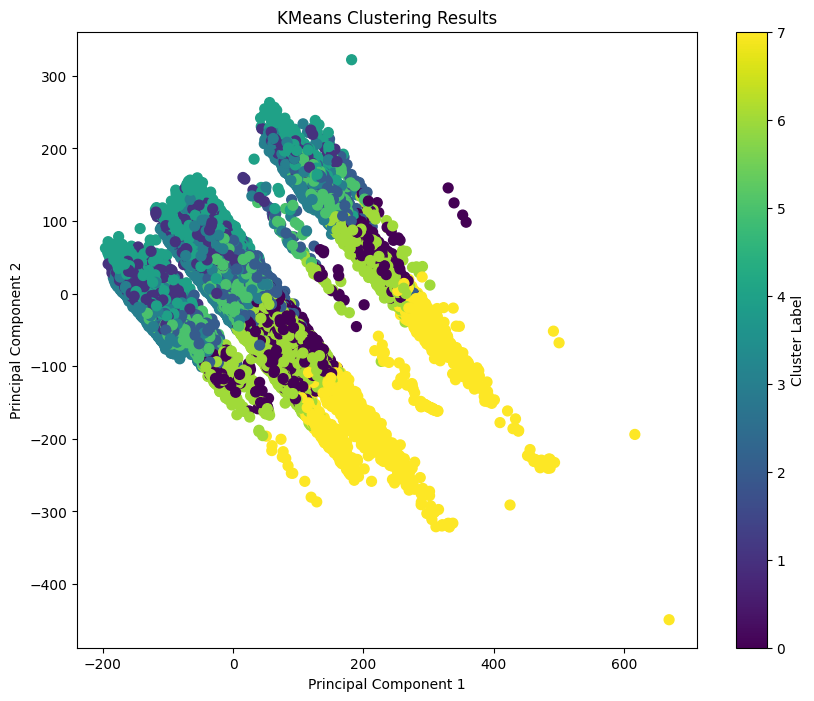

In [407]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(train_data_first_ten)

plt.figure(figsize=(10, 8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis', s=50)
plt.colorbar(label='Cluster Label')
plt.title('KMeans Clustering Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [408]:
def plot_mean():
    # Calculate the average SOC and Power for each cluster by taking the mean across all time steps
    cluster_avg_soc = train_data_first_ten.groupby('cluster')[SOC_COLOUMNS_SUBSET].mean().mean(axis=1)
    cluster_avg_power = train_data_first_ten.groupby('cluster')[POWER_COLOUMNS_SUBSET].mean().mean(axis=1)

    # Create a figure with two subplots: one for SOC and one for Power
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Bar chart for average SOC
    axes[0].bar(cluster_avg_soc.index, cluster_avg_soc.values, color='b')
    axes[0].set_title('Average SOC per Cluster')
    axes[0].set_xlabel('Cluster')
    axes[0].set_ylabel('Average SOC')
    axes[0].grid(True)

    # Bar chart for average Power
    axes[1].bar(cluster_avg_power.index, cluster_avg_power.values, color='r')
    axes[1].set_title('Average Power per Cluster')
    axes[1].set_xlabel('Cluster')
    axes[1].set_ylabel('Average Power')
    axes[1].grid(True)

    # Show the plots
    plt.tight_layout()
    plt.show()


In [409]:
def plot_variation():
    # Combine SOC and Power columns for plotting the boxplots
    # First, we will stack the SOC columns and Power columns for each cluster

    # Create a new DataFrame to hold SOC and Power values by cluster
    soc_data = train_data_first_ten.melt(id_vars=['cluster'], value_vars=SOC_COLOUMNS_SUBSET, var_name='SOC_Timestep', value_name='SOC')
    power_data = train_data_first_ten.melt(id_vars=['cluster'], value_vars=POWER_COLOUMNS_SUBSET, var_name='Power_Timestep', value_name='Power')

    # Set up a figure for the boxplot
    plt.figure(figsize=(18, 8))

    # Plot the SOC variation
    plt.subplot(1, 2, 1)
    sns.boxplot(x='cluster', y='SOC', data=soc_data, palette='Blues')
    plt.title('SOC Variation by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('SOC')

    # Plot the Power variation
    plt.subplot(1, 2, 2)
    sns.boxplot(x='cluster', y='Power', data=power_data, palette='Reds')
    plt.title('Power Variation by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Power')

    # Show the plots
    plt.tight_layout()
    plt.show()

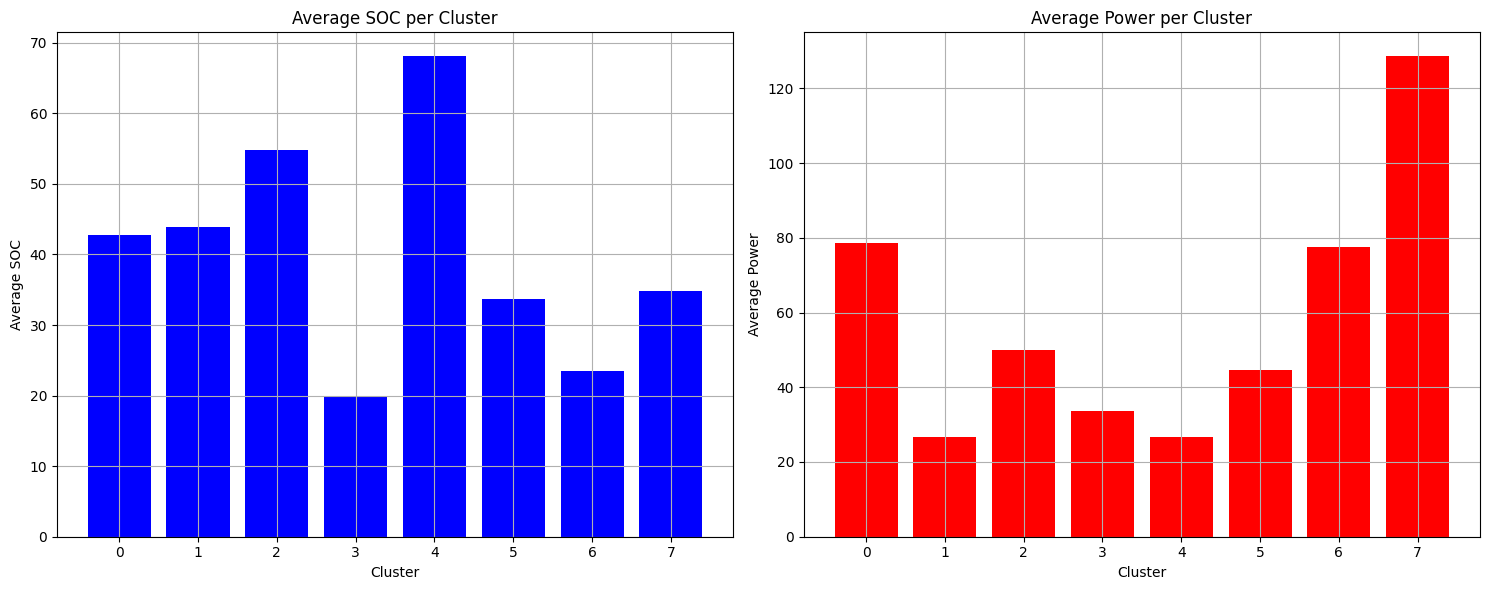

/tmp/ipykernel_24670/3570555530.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='SOC', data=soc_data, palette='Blues')
/tmp/ipykernel_24670/3570555530.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='Power', data=power_data, palette='Reds')


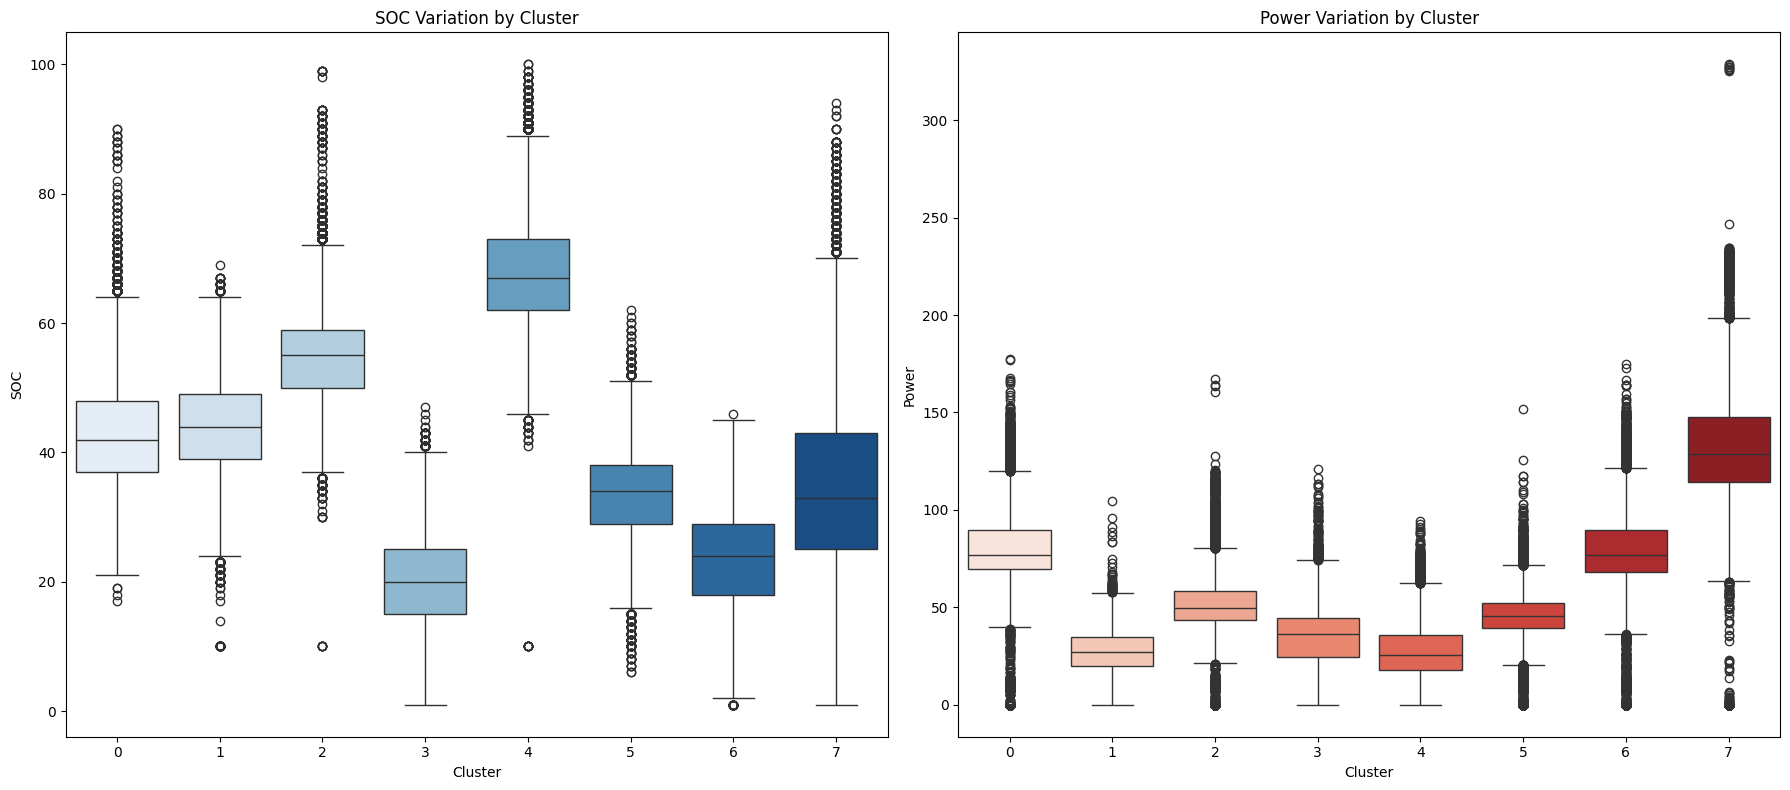

In [410]:
plot_mean()
plot_variation()

In [411]:
def get_model_pipeline():
    return Pipeline([
        ('scaler', MinMaxScaler()),
        ('poly', PolynomialFeatures()),
        ('regressor', MultiOutputRegressor(Ridge()))
    ])

In [412]:
INPUT_FEATURES_MODEL = SOC_COLOUMNS_SUBSET + POWER_COLOUMNS_SUBSET + ["nominal_power","location_id"] # timestamp
# todo location_id should be discrete
# todo add timestamp

TARGET_POWER = [f'power_{i}' for i in range(10, 40)]
TARGET_SOC = [f'soc_{i}' for i in range(10, 40)]

In [413]:
models = {}
for label in range(0, n_clusters_):
    train_subset = train_data[train_data['cluster'] == label]

    X_train_lin = train_subset[INPUT_FEATURES_MODEL]
    y_train_lin_power = train_subset[TARGET_POWER]

    pipeline_model = get_model_pipeline()
    pipeline_model.fit(X_train_lin, y_train_lin_power)
    
    models[label] = pipeline_model
    print(f"Trained model for cluster {label} on {len(train_subset)} samples.")


Trained model for cluster 0 on 6435 samples.
Trained model for cluster 1 on 10705 samples.
Trained model for cluster 2 on 8525 samples.
Trained model for cluster 3 on 12322 samples.
Trained model for cluster 4 on 6528 samples.
Trained model for cluster 5 on 13199 samples.
Trained model for cluster 6 on 7765 samples.
Trained model for cluster 7 on 2933 samples.


In [414]:
validation_scores = {}
for cluster, model in models.items():
    val_subset = validation_data[validation_data['cluster'] == cluster]

    X_val = val_subset[INPUT_FEATURES_MODEL]
    y_val = val_subset[TARGET_POWER]

    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)

    validation_scores[cluster] = mae
    print(f"Cluster {cluster}: MAE = {mae:.3f}")

Cluster 0: MAE = 7.228
Cluster 1: MAE = 4.403
Cluster 2: MAE = 5.725
Cluster 3: MAE = 5.719
Cluster 4: MAE = 3.893
Cluster 5: MAE = 5.320
Cluster 6: MAE = 9.036
Cluster 7: MAE = 11.083


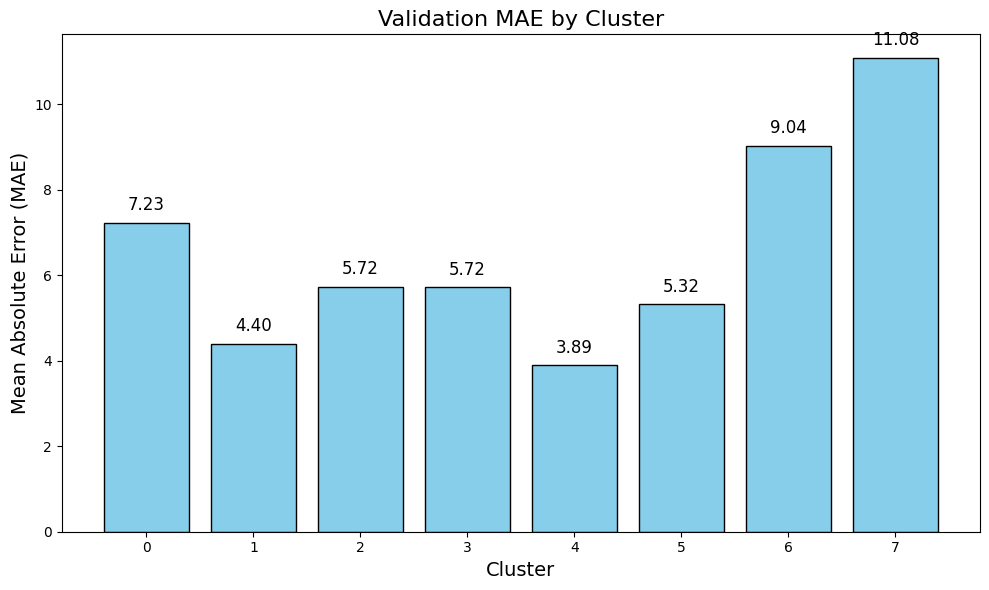

In [415]:
clusters = list(validation_scores.keys())
mae_values = list(validation_scores.values())

plt.figure(figsize=(10, 6))
plt.bar(clusters, mae_values, color='skyblue', edgecolor='black')
plt.xlabel("Cluster", fontsize=14)
plt.ylabel("Mean Absolute Error (MAE)", fontsize=14)
plt.title("Validation MAE by Cluster", fontsize=16)
plt.xticks(clusters)

for idx, mae in zip(clusters, mae_values):
    plt.text(idx, mae + 0.2, f"{mae:.2f}", ha="center", va="bottom", fontsize=12)
plt.tight_layout()
plt.show()


In [418]:
# Calculate weighted average MAE, using number of instances per cluster

total_instances = len(validation_data)
weighted_sum = 0

# Loop over each cluster and its MAE score.
# For each cluster, find the number of instances in that cluster and add mae * count.
for cluster, mae in validation_scores.items():
    count = len(validation_data[validation_data['cluster'] == cluster])
    weighted_sum += mae * count
    print(f"Cluster {cluster}: instances = {count}, MAE = {mae:.3f}")

weighted_avg_mae = weighted_sum / total_instances
print(f"\nTotal instances in validation data: {total_instances}")
print(f"Weighted Average MAE: {weighted_avg_mae:.3f}")

Cluster 0: instances = 1305, MAE = 7.228
Cluster 1: instances = 2158, MAE = 4.403
Cluster 2: instances = 1885, MAE = 5.725
Cluster 3: instances = 2722, MAE = 5.719
Cluster 4: instances = 1399, MAE = 3.893
Cluster 5: instances = 2868, MAE = 5.320
Cluster 6: instances = 1723, MAE = 9.036
Cluster 7: instances = 600, MAE = 11.083

Total instances in validation data: 14660
Weighted Average MAE: 6.018
